<center><img src="https://www.insight.com/content/dam/insight-web/logos/global-nav.svg" width='400'></center>
<br>
<font color='#544640'>
<center><i>Mastery 2019</i></center>
<center><i>Scottsdale, Arizona</i></center></font>
<center><i><font color='#544640' size='1'>Author: Victor Aranda</font></i></center></font>
<center><i><font color='#B81590' size='1'>victor.aranda@insight.com</font></i></center></font>
<hr>

# <font color="#D21087">Time Series Analysis</font>

<font color='#544640'>Time series analysis is a set of mathematical techniques for analyzing a sequence, or sequences, of data points to determine the characteristics of any underlying ***processes*** driving the changes in the values of the data points over time and model those changes to reproduce the original series from white noise. Phew!<br><br>

<font color='#544640'>In other words, stuff changes over time and it pays to be able to figure out how it will change in the future. Time series analysis is used as a tool for forecasting, primarily. Can you think of a few areas where this may be applicable or valuable?<br><br>

* Locale-specific tides versus lunar orbit and Earth rotation
* Financial markets analysis
* Compute/storage/network/etc utilization over time
* Electronic signals analysis, electronic warfare<br><br>

<font color='#544640'>There is a great deal of math behind all of this but we will not get into the weeds. Instead, we will learn the concepts behind some very fancy words which represent very powerful mathematic analytical tools. <br><br>

* AutoCorrelation and Partial AutoCorrelation (ACF & PACF)
* AutoRegressive Integrated Moving Average (ARIMA)
* AutoRegressive Conditional Heteroskedasticity (ARCH)
* Vector Error Correction Model (VECM)<br><br>

<font color='#544640'>In performing the analysis to forecast, we must understand some mathematical characteristics within the data. These characteristics can also be used to perform ***cluster*** and ***classify*** series. Where would that be useful?<br><br>

* Radio telescope, stellar spectral data, classifying stars
* Sonar, classifying oceanic animals, vehicles, submarines<br><br>



##### <font color="#D21087">Further Reading:</font>
    
https://en.wikipedia.org/wiki/Time_series

https://en.wikipedia.org/wiki/Stationary_process


<br><br><font color="#B81590">$$\large-\infty-$$</font><br><br>

In [0]:
# environment setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import statsmodels.api as sm
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import coint, grangercausalitytests
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.vector_ar.var_model import VARResults
from statsmodels.tsa.vector_ar.vecm import select_coint_rank, select_order, VECM
from statsmodels.tsa.arima_model import ARIMA, ARIMAResults
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

%matplotlib inline

<br><br><font color="#B81590">$$\large-\infty-$$</font><br><br>

## <font color="#D21087">Modeling a Time Series</font>

<font color='#544640'>Here we're going to model a time series (a set of data points along a period of time). 
    
<font color='#544640'>First we have to identify any ***auto-correlation*** or ***moving-average*** behavior. Then we'll effectively remove either term, if they exist, from the data according to the type we've uncovered (generally via a number of ***lags***).

In [0]:
# a helper function

def myADF(t, r = False):
    # t is a series of values, intended to be a time series
    # r is a boolean which determines if the p value is returned 
    #    INSTEAD OF displaying output
    # from Brownlee Ch 15.7
    result = adfuller(t)    
    if not r:
        # print results
        print('ADF Statistic:\t%f' % result[0])
        print('p-value:\t%f' % result[1])
        if result[1] > 0.05:
            print('\t\tSeries is non-stationary.')
        elif result[1] <= 0.05:
            print('\t\t\tSeries is stationary.')
        print('Critical Values:')
        for key, value in result[4].items():
            print('\t\t%s:\t%.3f' % (key, value))
    if r:
        return result[1] # return p

In [0]:
champ_df = pd.read_csv('https://raw.githubusercontent.com/kbreit/mastery19/master/intro_to_ai/data/champagne.csv', parse_dates=True, index_col=0, squeeze=True)

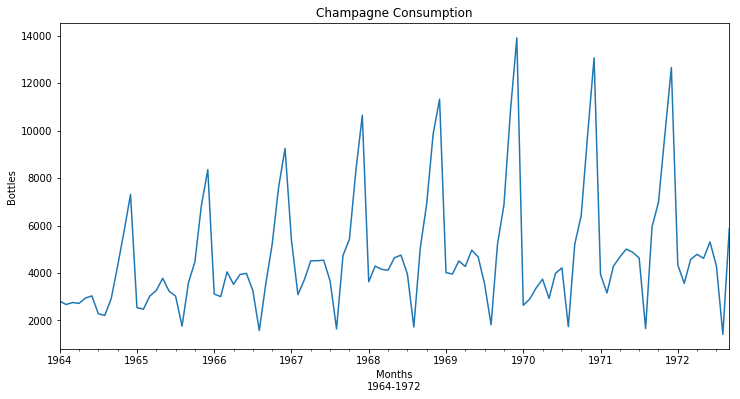

In [16]:
champ_df.plot(kind='line',figsize=[12,6])
plt.title("Champagne Consumption")
plt.xlabel('Months\n1964-1972')
plt.ylabel('Bottles')
plt.show()

<font color='#544640'>What behavior do you see in the data? Anything obvious?
    
We'll do a Dickey-Fuller test to see whether the series is ***stationary***.</font>

In [17]:
myADF(champ_df, r = False)

ADF Statistic:	-1.833593
p-value:	0.363916
		Series is non-stationary.
Critical Values:
		1%:	-3.503
		5%:	-2.893
		10%:	-2.584


<font color='#544640'>Let's decompose this series into different components - its trend and its seasonality. Trend is a ***moving-average*** and seasonality is ***auto-correlation***.

Note that this is a somewhat 'rough', or naive, sort of decomposition (it is not as rigorous as heavy-duty methods).</font>

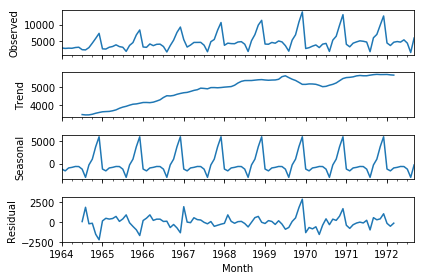

In [18]:
# we want to set the frequency of our analysis to 12 months based on a good hunch
result = seasonal_decompose(champ_df, model='additive', freq = 12)
result.plot()
plt.show()

<font color='#544640'>Clearly wine consumption is going up - and we know roughly how much without having to worry about other noise in the data.

Similarly we can clearly discern a very strong periodicity in the data, and we can isolate that periodicity from the trend and noise to analyze the yearly pattern. Surprise! People love drinking wine around New Year's Eve and the holidays.</font>

<center><img src='https://github.com/kbreit/mastery19/blob/master/intro_to_ai/img/leo.gif?raw=1'></center><br>

<font color='#544640'>What kinds of trending or seasonality do you see in your jobs?</font>

<br><br><font color="#B81590">$$\large-\infty-$$</font><br><br>

### <font color="#D21087">An ARIMA Model</font>

<font color='#544640'>Here we will model and forecast the data in `robberies.csv` based on an ARIMA(2,1,1) model. We'll hold back 25% of the data and only work with the remaining 75% to develop the model, and compare our forecast to the 25% after we're finished.

<font color='#544640'>While we're talking about ARIMA modeling,<br><br>
    
<font color='#544640'>$$\large \left(1-\sum _{i=1}^{p}\phi _{i}L^{i}\right)(1-L)^{d}X_{t}=\delta +\left(1+\sum _{i=1}^{q}\theta _{i}L^{i}\right)\varepsilon _{t}$$<br><br>

<center><img src='https://github.com/kbreit/mastery19/blob/master/intro_to_ai/img/math.jpg?raw=1' width='300'></center>

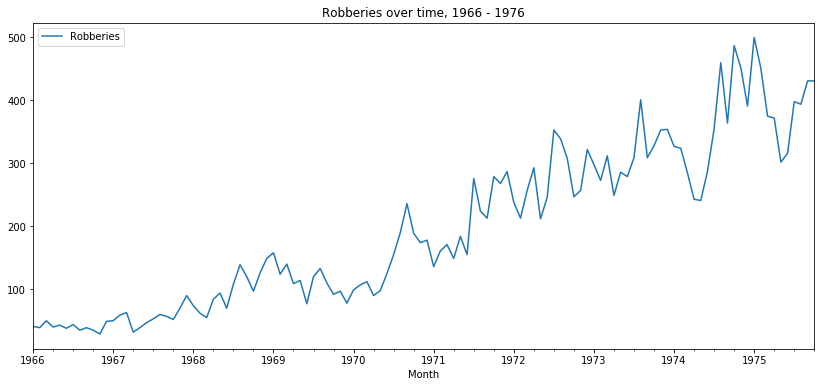

In [19]:
orig_df = pd.read_csv('https://raw.githubusercontent.com/kbreit/mastery19/master/intro_to_ai/data/robberies.csv', parse_dates=True, index_col=0)
rob1_df = orig_df.copy()
rob1_df.plot(kind='line',figsize=[14,6])
plt.title('Robberies over time, 1966 - 1976')
plt.show()

In [0]:
y = rob1_df.Robberies
y.index = pd.DatetimeIndex(y.index.values, freq = y.index.inferred_freq)
n = len(y)

ratio = 0.75

train = y.iloc[0:(int(round(ratio*n)))]
test = y.iloc[int(round(ratio*n)):n]

history = [x for x in train]

p = 2
d = 1
q = 1

model = ARIMA(history, order=(p,d,q))
model_fit = model.fit(disp=0)

# prediction time series
p_ts = pd.Series(model_fit.forecast(steps = len(test))[0], index = pd.DatetimeIndex(test.index.values, freq = test.index.inferred_freq))

limits = pd.DataFrame(model_fit.forecast(steps=len(test))[2])

# lower limit time series
ll_ts = pd.Series(limits[0])
ll_ts.index = pd.DatetimeIndex(test.index.values, freq = test.index.inferred_freq)

# upper limit time series
ul_ts = pd.Series(limits[1])
ul_ts.index = pd.DatetimeIndex(test.index.values, freq = test.index.inferred_freq)

# calculate intervals
interval_ts = ul_ts - ll_ts

# create a subset for zooming in
train_subset = train.iloc[int((.9*len(train))):len(train)]

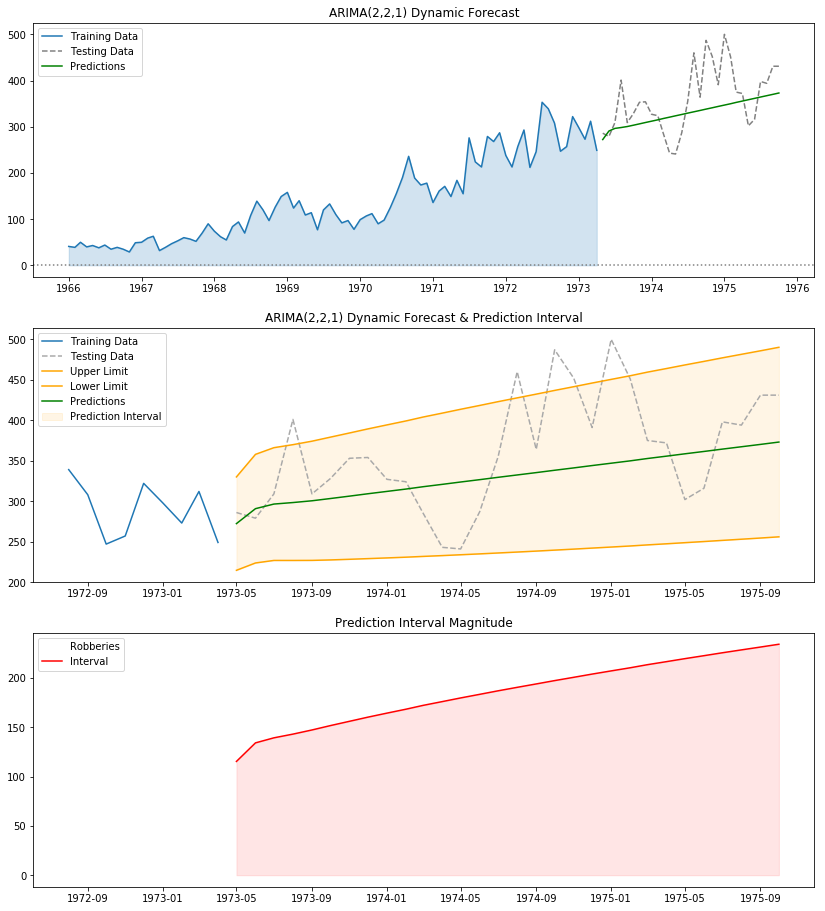

In [21]:
# plot
plt.figure(1,figsize=(14,6))

plt.subplot(311)
plt.plot(train,label='Training Data')
plt.fill_between(train.index, train, 0, color = '#1f77b4', alpha=.2)
plt.plot(test,label='Testing Data', color = 'gray', linestyle = '--')
plt.plot(p_ts,label='Predictions', color = 'green')
plt.title('ARIMA(2,2,1) Dynamic Forecast')
plt.legend()
plt.axhline(y=0, color='gray', linestyle=':')

# zoom in
plt.subplot(312)
plt.subplots_adjust(top=1,bottom=-1)
plt.plot(train_subset,label='Training Data')
plt.plot(test,label='Testing Data', color = 'darkgray', linestyle = '--')
plt.plot(ul_ts, color = 'orange',label='Upper Limit')
plt.plot(ll_ts, color = 'orange',label='Lower Limit')
plt.plot(p_ts,label='Predictions', color = 'green')
plt.fill_between(p_ts.index, ul_ts, ll_ts, color = 'orange', alpha = 0.1, label='Prediction Interval')
plt.title('ARIMA(2,2,1) Dynamic Forecast & Prediction Interval')
plt.legend()

# prediction interval magnitude
plt.subplot(313)

# include this subset to align plots
# adjust magnitude by .5 (or whatever) to get plot to 
# look right (in proportion to interval data)
plt.plot(train_subset*.5, color ='white')
plt.plot(interval_ts, label='Interval', color = 'red')
plt.fill_between(p_ts.index, interval_ts, 0, color = 'red', alpha=.1)
plt.title('Prediction Interval Magnitude')

plt.legend()
plt.show()

<br><br><font color="#B81590">$$\large-\infty-$$</font><br><br>

### <font color="#D21087">Predicting Potentially Co-Integrated Time Series</font>

In [0]:
# reading in the data
x_df = pd.read_csv('https://raw.githubusercontent.com/kbreit/mastery19/master/intro_to_ai/data/X.csv', index_col=0, names=['val'], header=0)
y_df = pd.read_csv('https://raw.githubusercontent.com/kbreit/mastery19/master/intro_to_ai/data/Y.csv', index_col=0, names=['val'], header=0)
z_df = pd.read_csv('https://raw.githubusercontent.com/kbreit/mastery19/master/intro_to_ai/data/Z.csv', index_col=0, names=['val'], header=0)

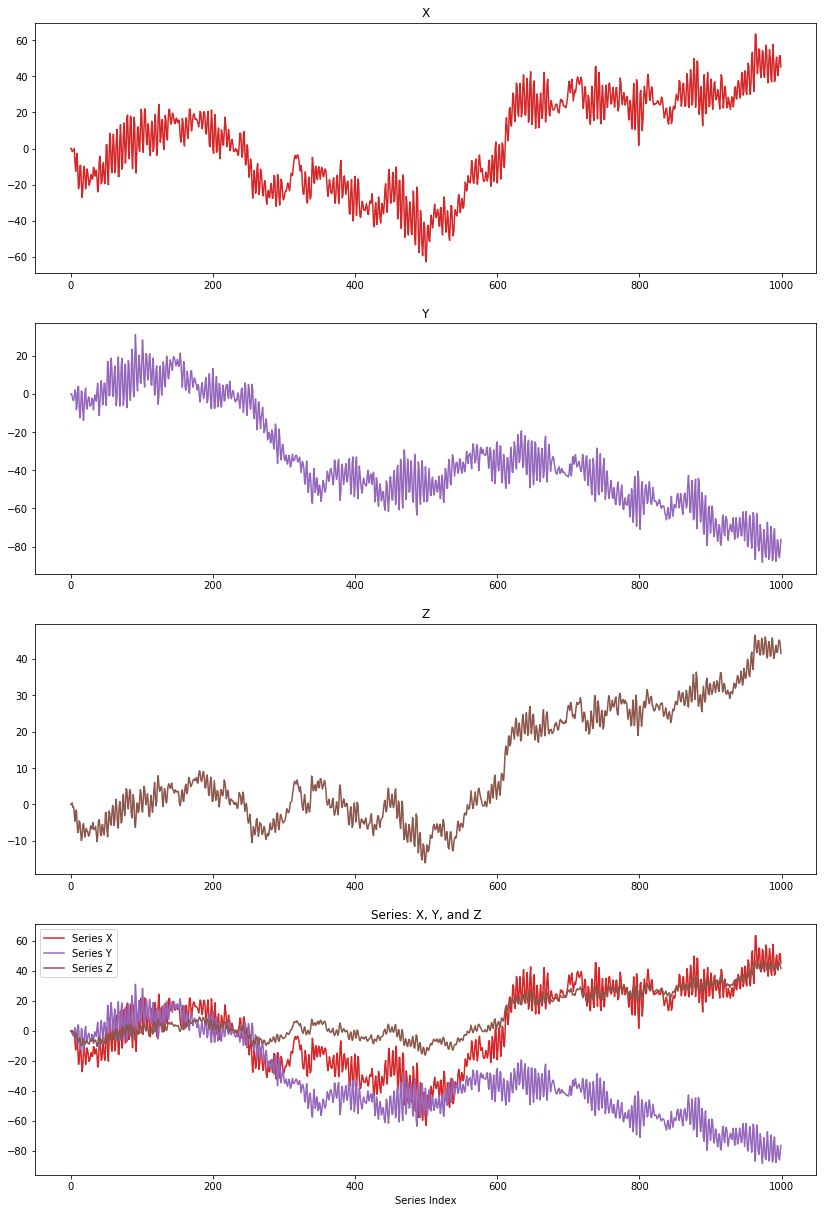

In [26]:
# plot the data and observe

plt.figure(1, figsize=(14, 8))
plt.subplots_adjust(top=1, bottom=-1)

plt.subplot(411)
plt.plot(x_df.index, x_df.val, color='#d62728')
plt.title('X')

plt.subplot(412)
plt.plot(y_df.index, y_df.val, color='#9467bd')
plt.title('Y')

plt.subplot(413)
plt.plot(z_df.index, z_df.val, color='#8c564b')
plt.title('Z')

plt.subplot(414)
plt.plot(x_df.index, x_df.val, label='Series X', color='#d62728')
plt.plot(y_df.index, y_df.val, label='Series Y', color='#9467bd')
plt.plot(z_df.index, z_df.val, label='Series Z', color='#8c564b')
plt.title('Series: X, Y, and Z')
plt.xlabel('Series Index')
plt.legend()

plt.show()

In [0]:
merge2_df = pd.DataFrame()
merge2_df['X'] = x_df.values.T[0]
merge2_df['Y'] = y_df.values.T[0]
merge2_df['Z'] = z_df.values.T[0]

In [0]:
merge2_df.index = pd.DatetimeIndex(merge2_df.index.values)
merge2_df.index.freq = merge2_df.index.inferred_freq
# merge2_df.head()

In [0]:
model2 = VAR(merge2_df)
lag_order = model2.select_order(20)
#print(lag_order.summary())
# Best VAR lag order is p=2 based on Akaike Information Criterion (AIC)

In [0]:
results2 = model2.fit(2)
# print(results2.summary())

In [59]:
n_variables = 3
n_lags = 2
n_roots = n_variables * n_lags

VAR_results2 = VARResults.roots(results2)

print('Roots:')
for i in range(n_roots):
    print('  ' + str(round(VAR_results2[i],3)))

print('\nModuli:')
for i in range(n_roots):
    print('  ' + str(round(np.absolute(VAR_results2[i]),3)))

Roots:
  (21.584-0j)
  (2.296-0j)
  (0.289+0.989j)
  (0.289-0.989j)
  (1.004-0j)
  (0.999-0j)

Moduli:
  21.584
  2.296
  1.03
  1.03
  1.004
  0.999


<font color='#544640'>We can tell that the model we have built around these time series is not ***stationary*** (that is somewhat obvious from the plot). We can also determine that the series are not ***cointegrated***.</font>

In [61]:
lag_order2 = select_order(data=merge2_df, maxlags=10, deterministic='nc')
print(lag_order2.summary())
print()
print('AIC lag order = ', lag_order2.aic)

 VECM Order Selection (* highlights the minimums) 
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        3.530       3.590       34.14       3.553
1     0.01938*     0.1234*      1.020*    0.05892*
2      0.03053      0.1791       1.031     0.08701
3      0.04085      0.2339       1.042      0.1143
4      0.04980      0.2875       1.051      0.1402
5      0.06059      0.3428       1.062      0.1679
6      0.07137      0.3981       1.074      0.1956
7      0.08619      0.4575       1.090      0.2274
8      0.09589      0.5118       1.101      0.2540
9      0.09554      0.5560       1.100      0.2706
10      0.1062      0.6112       1.112      0.2983
--------------------------------------------------

AIC lag order =  1


In [60]:
rank_test2 = select_coint_rank(merge2_df, 0, 1, method='trace', signif=0.05)
print(rank_test2)
print()
print('Rank = ' + str(rank_test2.rank))

Johansen cointegration test using trace test statistic with 5% significance level
r_0 r_1 test statistic critical value
-------------------------------------
  0   3          792.0          29.80
  1   3          2.626          15.49
-------------------------------------

Rank = 1


<font color='#544640'>We can create a VECM model for this data given what we know about it. The VECM model can predict what the series will look like a few steps ahead, based on our analysis of the time series.</font>

In [0]:
model2 = VECM(
    merge2_df,
    deterministic='nc',
    k_ar_diff=lag_order2.aic,
    coint_rank=rank_test2.rank)

vecm_res = model2.fit()
# print(vecm_res.summary())

# print(vecm_res.alpha)
# print(vecm_res.beta)

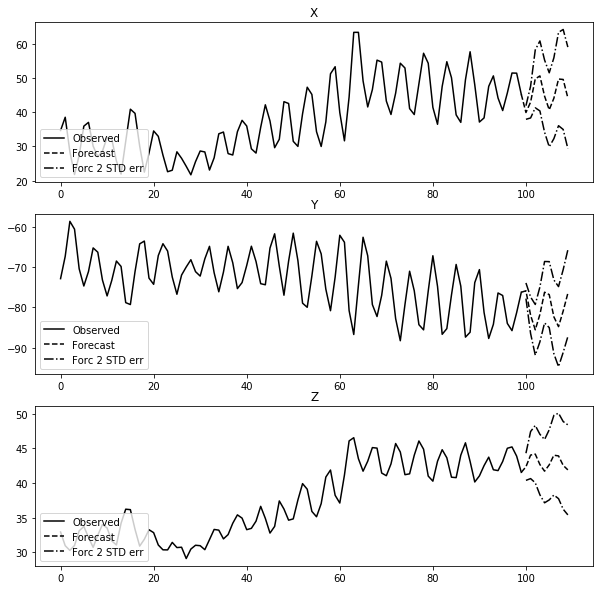

In [65]:
# predict 10 steps ahead
vecm_res.predict(steps=10, alpha=.05)

# for text, values in zip(('forecast','lower','upper'), vecm_res.predict(steps=10, alpha=.05)):
#     print(text+' : ', values, sep='\n')

vecm_res.plot_forecast(steps=10, plot_conf_int=True, n_last_obs=100)
plt.show()


<font color='#544640'>A bit closer now...</font>

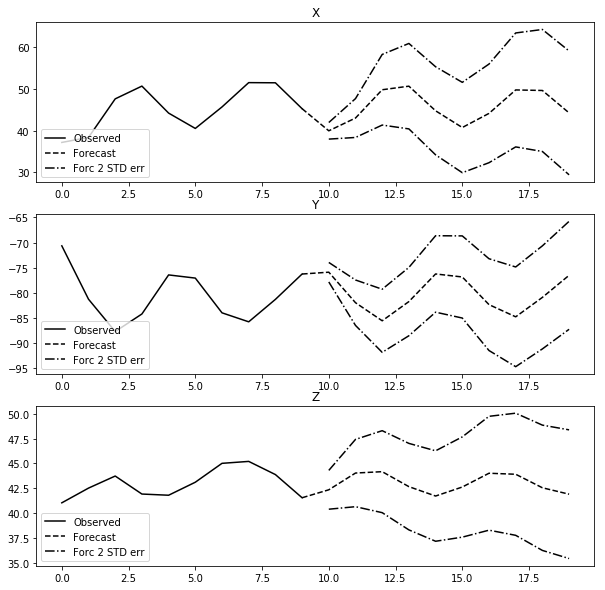

In [66]:
vecm_res.plot_forecast(steps=10, n_last_obs=10)

<br><br><font color="#B81590">$$\large-\infty-$$</font><br><br>

## <font color="#D21087">Sun Spots</font>

> Sunspots are temporary phenomena on the Sun's photosphere that appear as spots darker than the surrounding areas. They are regions of reduced surface temperature caused by concentrations of magnetic field flux that inhibit convection. Sunspots usually appear in pairs of opposite magnetic polarity. Their number varies according to the approximately 11-year solar cycle.

https://en.wikipedia.org/wiki/Sunspot<br><br>


<center><img src='https://github.com/kbreit/mastery19/blob/master/intro_to_ai/img/sun.gif?raw=1'></center>

<font color='#544640'>Astronomers have been studying the sunspot cycle since at least 800 BC. Starting in the mid 1700s, detailed record-keeping eventually produced this data set (1749-1983) of the number of sunspots in each month of the year.
    
Based on the Auto-Correlation Function (ACF) of the `sunspots.csv` dataset, what is the sunspot cycle to the nearest month? Let's find out.</font>

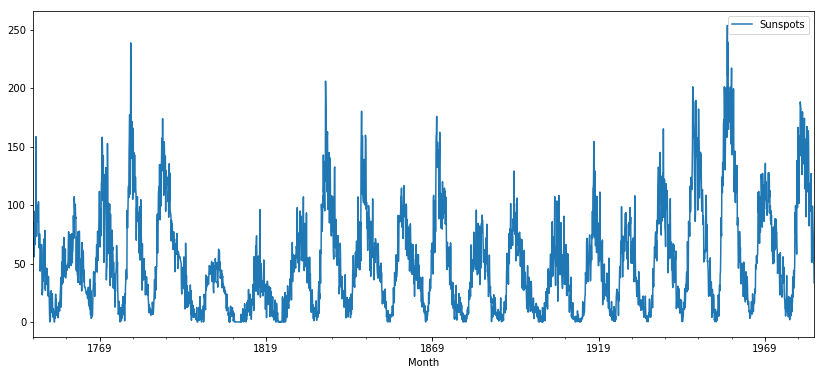

In [68]:
sunspots = pd.read_csv('https://raw.githubusercontent.com/kbreit/mastery19/master/intro_to_ai/data/sunspots.csv', parse_dates=True, index_col=0)
sunspots.plot(kind='line',figsize=[14,6])
plt.show()

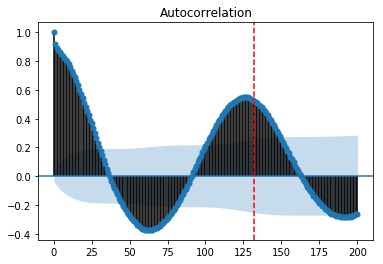

In [69]:
plot_acf(sunspots,lags=200)
plt.axvline(x=12*11, color='red', linestyle='--', ) # estimated 11 year cycle
plt.show()

<font color='#544640'>We note that the first peak of the ACF's curve is a bit shy of the estimated 11-year (132-month) cycle. To find the value where the ACF peaks, we will do the following:</font>

In [76]:
# let's consider just the number of lags around the auto-correlation peak
#   100 - 150 lags
# find the max position of that portion of the ACF
# add 100 (because we removed 100 when 'zooming in')
period_months = acf(sunspots, nlags=200, fft=False)[100:150].argmax() + 100

print('The sunspot period appears to be ' + np.str(round(period_months/12,2)) + ' years (' + np.str(period_months) + ' months).')

The sunspot period appears to be 10.42 years (125 months).


<br><br><font color="#B81590">$$\large-\infty-$$</font><br><br>

<font color='#544640'>Putting it all together, hopefully you can enjoy the wit and humor of these authors' when they titled their paper:</font><br><br>

<center><img src='https://github.com/kbreit/mastery19/blob/master/intro_to_ai/img/multiple_coint_ec.png?raw=1' width=600></center>